# Öğrenme Aktarımı

Görüntü sınıflandırması için bir Konvolüsyonel Sinir Ağı (CNN), kenarlar, köşeler vb. gibi özellikleri çıkaran çok sayıda katmandan oluşur; ve ardından nesneleri bu özelliklere göre sınıflandırmak için son bir tam bağlantılı katman kullanın. Bunu şu şekilde görselleştirebilirsiniz:

<table>
    <tr><td rowspan=2 style='border: 1px solid black;'>&#x21d2;</td><td style='border: 1px solid black;'>Convolutional Layer</td><td style='border: 1px solid black;'>Pooling Layer</td><td style='border: 1px solid black;'>Convolutional Layer</td><td style='border: 1px solid black;'>Pooling Layer</td><td style='border: 1px solid black;'>Fully Connected Layer</td><td rowspan=2 style='border: 1px solid black;'>&#x21d2;</td></tr>
    <tr><td colspan=4 style='border: 1px solid black; text-align:center;'>Feature Extraction</td><td style='border: 1px solid black; text-align:center;'>Classification</td></tr>
</table>

*Transfer Learning*, mevcut eğitilmiş bir modeli alıp onun özellik çıkarma katmanlarını yeniden kullanabileceğiniz, son sınıflandırma katmanını kendi özel görüntüleriniz üzerinde eğitilmiş tamamen bağlantılı bir katmanla değiştirebileceğiniz bir tekniktir. Bu teknikle, modeliniz, kendi özel nesne sınıfları kümeniz için bir sınıflandırma modeli oluşturmak üzere temel modelde gerçekleştirilen (erişiminizin olduğundan daha büyük bir eğitim veri kümesine dayalı olabilir) özellik çıkarma eğitiminden yararlanır.

Bu nasıl yardımcı olur? Peki, şöyle düşün. Farz edin ki profesyonel bir tenis oyuncusunu ve acemi bir tenisçiyi alıp her ikisine de raketbol oynamayı öğretmeye çalışıyorsunuz. Profesyonel tenis oyuncusunun daha kolay eğitileceğini varsaymak mantıklıdır, çünkü raketbolda yer alan temel becerilerin çoğu zaten öğrenilmiştir. Benzer şekilde, önceden eğitilmiş bir CNN modelinin, belirli nesne kümelerini sınıflandırmak için eğitilmesi daha kolay olabilir çünkü zaten kenarlar ve köşeler gibi ortak nesnelerin özelliklerinin nasıl tanımlanacağını öğrenmiştir. Temel olarak, önceden eğitilmiş bir model, onu eğitmek için sınırlı veriye sahip olduğunuzda bile etkili bir sınıflandırıcı üretmenin harika bir yolu olabilir.

## TensorFlow kitaplıklarını yükleme

**TensorFlow** paketinin en son sürümünün kurulu olduğundan emin olarak ve kullanacağımız Tensorflow kitaplıklarını içe aktararak başlayalım.

In [2]:
import tensorflow
from  tensorflow import keras

In [3]:
print("TensorFlow version:",tensorflow.__version__)
print("Keras version:",keras.__version__)

TensorFlow version: 2.12.0
Keras version: 2.12.0


## Temel modeli hazırlama

Transfer öğrenmeyi kullanmak için, eğitilmiş öznitelik çıkarma katmanlarını kullanabileceğimiz bir temel modele ihtiyacımız var. ***resnet*** modeli, 224x224 piksellik 3 renkli kanal görüntülerinden oluşan devasa bir veri kümesi kullanılarak önceden eğitilmiş CNN tabanlı bir görüntü sınıflandırıcıdır. Son (üst) tahmin katmanı hariç, önceden eğitilmiş bazı ağırlıklarla bunun bir örneğini oluşturalım.

In [4]:
base_model = keras.applications.resnet.ResNet50(weights="imagenet",
                                                # Bu, ResNet50 modelinin ImageNet veri kümesi üzerinde önceden eğitilmiş 
                                                # ağırlıklarını kullanmak istediğinizi belirtir. Bu ağırlıklar, çeşitli nesneler
                                                # ve desenler için geniş bir özellik yelpazesini yakalar ve transfer öğrenme 
                                                # için harika bir başlangıç noktası oluşturur.
                                                include_top=False,
                                                # ResNet50 modelinin tamamen bağlı katmanlarını (üst katmanları) dahil 
                                                # etmiyorsunuz. Üst katmanları çıkartarak, kendi özel sınıflandırıcılarınızı 
                                                # temel modelin üzerine ekleyebilirsiniz.
                                                input_shape=(224,224,3))
                                                # Bu, modelin 224x224 piksel çözünürlüğünde ve 3 renk kanalına (RGB) sahip 
                                                # görüntüleri giriş olarak beklediği anlamına gelir. 
print(base_model.summary())

94765736/94765736 [==============================] - 50s 1us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                         

 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
          

 conv3_block3_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block1_out[0][0]']       
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
          

                                )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

                                                                                                  
 conv5_block1_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_0_bn[0][0]',      
                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
          

## Görüntü verilerini hazırlama

Önceden eğitilmiş model, görüntü verilerinden özellik çıkarma sürecini başlatan evrişimli bir katmanla başlayan birçok katmana sahiptir.

Özellik çıkarmanın kendi görüntülerimizle çalışması için, tahmin katmanımızı eğitmek için kullandığımız görüntü verilerinin, özellik çıkarma katmanlarını eğitmek için orijinal olarak kullanılan görüntülerle aynı sayıda özelliğe (piksel değerleri) sahip olduğundan emin olmamız gerekir. 224x224 piksel boyutunda renkli görüntüler için veri yükleyiciler.

Tensorflow, verileri yüklemek ve dönüştürmek için işlevler içerir. Bunları, eğitim verileri için bir oluşturucu ve test verileri için (eğitilmiş modeli doğrulamak için kullanacağımız) ikinci bir oluşturucu oluşturmak için kullanacağız. Yükleyiciler, görüntü verilerini orijinal resnet CNN modelini eğitmek ve normalleştirmek için kullanılan formatla eşleşecek şekilde dönüştürecektir.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
data_folder = r"C:\Users\PC\Documents\Machine Learning Challenge\Notebook\shapes"
pretrained_size = (224, 224)
batch_size = 30

In [8]:
print("Veri Alınıyor...")
datagen = ImageDataGenerator(rescale=1./255, # piksel değerlerini normalleştirin
                             validation_split=0.3) # doğrulama için görüntülerin %30'unu geri alın

Veri Alınıyor...


In [9]:
print("Eğitim veri seti hazırlanıyor...")
train_generator = datagen.flow_from_directory(data_folder,
                                              target_size=pretrained_size, 
                                              # modelin beklenen girdisiyle eşleşecek şekilde yeniden boyutlandırın
                                              batch_size=batch_size,
                                              class_mode="categorical",
                                              subset="training")
                                              # eğitim verisi olarak ayarlayın

Eğitim veri seti hazırlanıyor...
Found 840 images belonging to 3 classes.


In [10]:
print("Doğrulama veri kümesi hazırlanıyor...")
validation_generator = datagen.flow_from_directory(data_folder,
                                                   target_size=pretrained_size, 
                                                   # modelin beklenen girdisiyle eşleşecek şekilde yeniden boyutlandırın
                                                   batch_size=batch_size,
                                                   class_mode="categorical",
                                                   subset="validation")
                                                   # doğrulama verisi olarak ayarlayın

Doğrulama veri kümesi hazırlanıyor...
Found 360 images belonging to 3 classes.


In [11]:
classnames = list(train_generator.class_indices.keys())
print("class names: ", classnames)

class names:  ['circle', 'square', 'triangle']


## Bir tahmin katmanı oluşturma

Son tahmin katmanı hariç tüm *resnet* modelini indirdik, bu nedenle bu katmanları, özellik çıkarma katmanlarından düzleştirilmiş çıktıları alan ve görüntümüzün her biri için bir tahmin oluşturan tam bağlantılı (*yoğun*) bir katmanla birleştirmemiz gerekiyor. 
Eğitilmiş ağırlıkları korumak için özellik çıkarma katmanlarını da dondurmamız gerekiyor. Ardından, görüntülerimizi kullanarak modeli eğittiğimizde, yalnızca son tahmin katmanı yeni ağırlık ve yanlılık değerlerini öğrenecek - özellik çıkarma için önceden öğrenilen önceden eğitilmiş ağırlıklar aynı kalacaktır.

In [12]:
from tensorflow.keras import applications
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense

In [13]:
# Temel modelde önceden eğitilmiş katmanları dondurun
for layer in base_model.layers:
    layer.trainable = False
    
# Görüntülerimizin sınıflandırılması için tahmin katmanı oluşturun
x = base_model.output
x = Flatten()(x)
prediction_layer = Dense(len(classnames), activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=prediction_layer)

# Modeli derleyin
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Şimdi, temel modelin katmanlarını ve eklediğimiz yoğun katmanı içerecek tam modeli yazdırın
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

## Modeli Eğitme

CNN'in katmanları tanımlandıktan sonra, görüntü verilerimizi kullanarak onu eğitmeye hazırız. Temel resnet modelinden özellik çıkarma katmanlarında kullanılan ağırlıklar eğitim ile değiştirilmeyecek, sadece özellikleri şekil sınıflarımıza eşleyen son yoğun katman eğitilecektir.

In [14]:
# Modeli 3 dönem boyunca eğitin
num_epochs = 3
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    epochs=num_epochs)

Epoch 1/3
28/28 [==============================] - 199s 7s/step - loss: 3.1148 - accuracy: 0.5000 - val_loss: 0.5230 - val_accuracy: 0.6556
Epoch 2/3
28/28 [==============================] - 205s 7s/step - loss: 0.3020 - accuracy: 0.8738 - val_loss: 0.1663 - val_accuracy: 0.9417
Epoch 3/3
28/28 [==============================] - 205s 7s/step - loss: 0.1892 - accuracy: 0.9345 - val_loss: 0.1210 - val_accuracy: 0.9889


## Kayıp geçmişini görüntüleme

Her dönem için ortalama eğitim ve doğrulama kaybını takip ettik. Bunları, eğitim sürecinde kaybın azaldığını doğrulamak ve *fazla uydurmayı* tespit etmek için çizebiliriz (bu, doğrulama kaybı dengelendikten veya artmaya başladıktan sonra eğitim kaybında devam eden düşüşle gösterilir).

In [15]:
from matplotlib import pyplot as plt

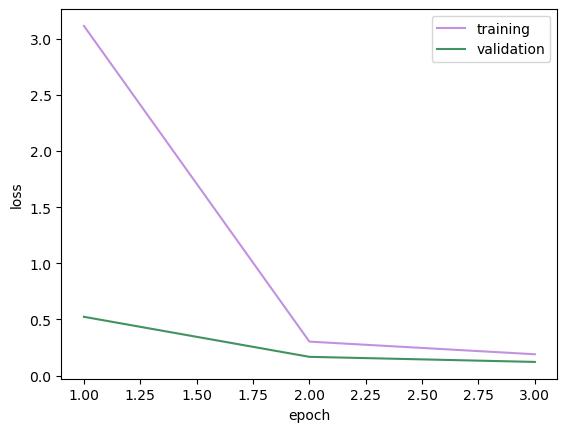

In [16]:
epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss, color="#c292e0")
plt.plot(epoch_nums, validation_loss, color="#41925e")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["training", "validation"], loc="upper right")
plt.show()

## Model performansını değerlendirme

Test verilerine dayalı olarak nihai doğruluğu görebiliriz, ancak genellikle performans metriklerini biraz daha derinlemesine araştırmak isteriz. Modelin her sınıfı ne kadar iyi tahmin ettiğini görmek için bir karışıklık matrisi çizelim.

In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np

Doğrulama verilerinden tahminler oluşturuluyor...
1/1 [==============================] - 2s 2s/step


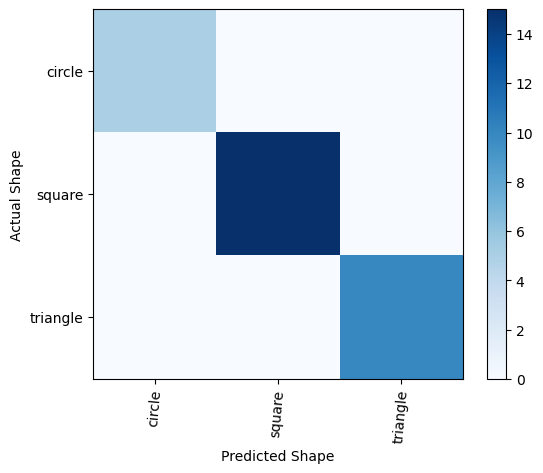

In [20]:
print("Doğrulama verilerinden tahminler oluşturuluyor...")
# Doğrulama verilerinin ilk grubu için görüntü ve etiket dizilerini alın
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Sınıfı tahmin etmek için modeli kullanın
class_probabilities = model.predict(x_test)

# Model, her sınıf için bir olasılık değeri döndürür
# Olasılığı en yüksek olan tahmin edilen sınıftır
predictions = np.argmax(class_probabilities, axis=1)

# Gerçek etiketler sıcak kodlanmıştır (ör. [0 1 0], bu nedenle 1 değerine sahip olanı alın
true_labels = np.argmax(y_test, axis=1)

# Karışıklık matrisini çizin
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

## Eğitimli modeli kullanma

Artık modeli eğittiğimize göre, onu bir görüntünün sınıfını tahmin etmek için kullanabiliriz.

In [21]:
from tensorflow.keras import models
from random import randint
import os

In [22]:
# Bir görüntünün sınıfını tahmin etme işlevi
def predict_image(classifier, image):
    from tensorflow import convert_to_tensor
    # Model, girdi olarak bir dizi görüntü bekliyor, bu nedenle 1 görüntüden oluşan bir dizi oluşturacağız
    imgfeatures = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

    # Girdiyi eğitim verileriyle eşleşecek şekilde biçimlendirmemiz gerekiyor
    # Oluşturucu, değerleri kayan noktalı sayılar olarak yükledi
    # ve piksel değerlerini normalleştirdi, yani...
    imgfeatures = imgfeatures.astype("float32")
    imgfeatures /= 255
    
    # Görüntü sınıfını tahmin etmek için modeli kullanın
    class_probabilities = classifier.predict(imgfeatures)
    
    # Tahmin edilen en yüksek olasılığa sahip sınıf tahminlerini bulun
    index = int(np.argmax(class_probabilities, axis=1)[0])
    return index

In [23]:
# Rastgele bir görüntü oluşturma işlevi (kare, daire veya üçgenden)
def create_image (size, shape):
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == "circle":
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == "triangle":
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return np.array(img)


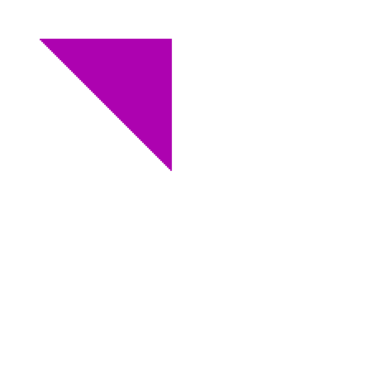

In [25]:
# Rastgele bir test görüntüsü oluşturun
classnames = os.listdir(data_folder)
classnames.sort()
img = create_image ((224,224), classnames[randint(0, len(classnames)-1)])
plt.axis("off")
plt.imshow(img)

In [26]:
# Sınıfı tahmin etmek için sınıflandırıcıyı kullanın
class_idx = predict_image(model, img)
print (classnames[class_idx])

1/1 [==============================] - 0s 220ms/step
triangle
